# Tradução Automática

Esse tutorial foi realizado seguindo o passo a passo da seção 9.5 do Dive into Deep Learning, disponível no link: https://pt.d2l.ai/chapter_recurrent-modern/machine-translation-and-dataset.html

In [29]:
# Instala dependências
!pip install numpy==1.26.4
!pip install git+https://github.com/d2l-ai/d2l-en --no-deps


# Importa bibliotecas
import os
import tensorflow as tf
from tensorflow.keras import layers
from d2l import tensorflow as d2l
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import f1_score
import numpy as np



  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-dh_4txeo
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-dh_4txeo
  Resolved https://github.com/d2l-ai/d2l-en to commit 23d7a5aecceee57d1292c56e90cce307f183bb0a
  Preparing metadata (setup.py) ... done


## Download do Dataset do Projeto Tatoeba

In [30]:
# Download Dataset
d2l.DATA_HUB['fra-eng'] = (
    d2l.DATA_URL + 'fra-eng.zip',
    '94646ad1522d915e7b0f9296181140edcf86a4f5'
)

def read_data_nmt():
    """
    Lê o dataset de tradução automática Inglês–Francês.

    Passos executados:
    - Faz o download do dataset a partir do DATA_HUB (se ainda não estiver na máquina).
    - Extrai o arquivo ZIP.
    - Abre o arquivo 'fra.txt' (que contém as frases pareadas Inglês–Francês).
    - Retorna o conteúdo bruto do arquivo como uma string única.
    """
    data_dir = d2l.download_extract('fra-eng')  # baixa e extrai os arquivos
    with open(os.path.join(data_dir, 'fra.txt'), 'r', encoding="utf-8") as f:
        return f.read()

# Carrega o dataset bruto em uma string
raw_text = read_data_nmt()

# Visualiza apenas os primeiros 75 caracteres para inspecionar o formato
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



## Análise do dataset do Projeto Tatoeba

Dimensão do dataset: (167130, 2)
  english    french
0     Go.      Va !
1     Hi.   Salut !
2    Run!   Cours !
3    Run!  Courez !
4    Who?     Qui ?

--- Estatísticas Inglês (tokens) ---
count    167130.000000
mean          6.151469
std           2.475642
min           1.000000
25%           4.000000
50%           6.000000
75%           7.000000
max          47.000000
Name: len_en_tokens, dtype: float64

--- Estatísticas Francês (tokens) ---
count    167130.000000
mean          6.693454
std           2.779339
min           1.000000
25%           5.000000
50%           6.000000
75%           8.000000
max          54.000000
Name: len_fr_tokens, dtype: float64


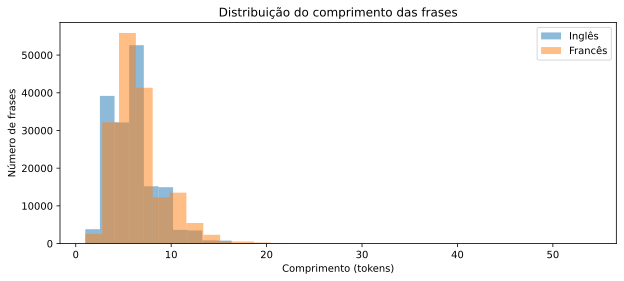


Top 20 palavras em Inglês:
[('i', 45541), ('you', 36616), ('to', 36231), ('the', 33263), ('a', 23950), ('is', 16362), ('tom', 12537), ('he', 12083), ('of', 11178), ('do', 10201), ('in', 9975), ("don't", 9606), ('have', 9510), ('that', 9364), ('was', 8696), ('this', 8526), ('my', 8095), ('it', 7572), ('are', 7481), ('your', 7481)]

Top 20 palavras em Francês:
[('je', 39821), ('de', 35073), ('?', 27157), ('pas', 25403), ('que', 23987), ('à', 21006), ('ne', 20231), ('le', 19487), ('la', 19203), ('vous', 17141), ('il', 15465), ('tom', 12926), ('est', 12560), ('un', 11979), ('ce', 11606), ('a', 11129), ('tu', 10996), ('nous', 10358), ('en', 9103), ('les', 8838)]

Tamanho do vocabulário inglês: 25365
Tamanho do vocabulário francês: 42025


In [31]:
# Carregar dataset bruto
raw_text = read_data_nmt()
lines = raw_text.split("\n")
pairs = [l.split("\t") for l in lines if "\t" in l]

# Converter para DataFrame para facilitar a exploração
df = pd.DataFrame(pairs, columns=["english", "french"])
print("Dimensão do dataset:", df.shape)
print(df.head())

# Comprimento em caracteres e tokens
df["len_en_chars"] = df["english"].str.len()
df["len_fr_chars"] = df["french"].str.len()
df["len_en_tokens"] = df["english"].str.split().apply(len)
df["len_fr_tokens"] = df["french"].str.split().apply(len)

# Estatísticas descritivas
print("\n--- Estatísticas Inglês (tokens) ---")
print(df["len_en_tokens"].describe())
print("\n--- Estatísticas Francês (tokens) ---")
print(df["len_fr_tokens"].describe())

# Histogramas de comprimento
plt.figure(figsize=(10,4))
plt.hist(df["len_en_tokens"], bins=30, alpha=0.5, label="Inglês")
plt.hist(df["len_fr_tokens"], bins=30, alpha=0.5, label="Francês")
plt.xlabel("Comprimento (tokens)")
plt.ylabel("Número de frases")
plt.legend()
plt.title("Distribuição do comprimento das frases")
plt.show()

# Frequência de palavras (top 20)
en_tokens = [w for sent in df["english"].str.lower().str.split() for w in sent]
fr_tokens = [w for sent in df["french"].str.lower().str.split() for w in sent]

en_freq = Counter(en_tokens)
fr_freq = Counter(fr_tokens)

print("\nTop 20 palavras em Inglês:")
print(en_freq.most_common(20))

print("\nTop 20 palavras em Francês:")
print(fr_freq.most_common(20))

# Tamanho dos vocabulários
print("\nTamanho do vocabulário inglês:", len(en_freq))
print("Tamanho do vocabulário francês:", len(fr_freq))


## Pré-processamento do conjunto de dados

In [32]:
def preprocess_nmt(text):
    """
    Pré-processa o dataset Inglês–Francês para tradução automática.

    Etapas realizadas:
    - Substitui espaços não separáveis (non-breaking spaces) por espaços normais.
    - Converte todas as letras maiúsculas para minúsculas.
    - Garante que haja um espaço entre palavras e sinais de pontuação
       (por exemplo: "hello!" -> "hello !").
    """

    def no_space(char, prev_char):
        """
        Verifica se o caractere atual é um sinal de pontuação (.,!?)
        e se ele não está precedido por um espaço.
        Usada para decidir se devemos inserir um espaço antes da pontuação.
        """
        return char in set(',.!?') and prev_char != ' '

    # Substitui espaços "especiais" por espaço normal e transforma todas as letras em minúsculas
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()

    # Insere espaço antes de sinais de pontuação, quando necessário
    out = [
        ' ' + char if i > 0 and no_space(char, text[i - 1]) else char
        for i, char in enumerate(text)
    ]

    # Retorna o texto pré-processado como uma única string
    return ''.join(out)


# Aplica o pré-processamento ao texto bruto carregado anteriormente
text = preprocess_nmt(raw_text)

# Mostra os primeiros 80 caracteres para verificar o resultado
print(text[:80])


go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


## Tokenização

In [33]:
def tokenize_nmt(text, num_examples=None):
    """
    Tokeniza o dataset Inglês–Francês para tradução automática.

    Parâmetros
    ----------
    text : str
        Texto bruto já pré-processado, contendo frases em inglês e francês
        separadas por tabulação ('\t'), uma por linha.
    num_examples : int, opcional
        Número máximo de exemplos a serem processados (útil para testes rápidos).
        Se None, processa todo o dataset.

    Retorna
    -------
    source : list[list[str]]
        Lista de frases em inglês, onde cada frase é representada como uma lista de tokens (palavras).
    target : list[list[str]]
        Lista de frases em francês, também tokenizadas em listas de palavras.
    """
    source, target = [], []  # listas para armazenar as frases tokenizadas

    # Percorre cada linha do texto
    for i, line in enumerate(text.split('\n')):
        # Se for definido um limite de exemplos, interrompe o loop ao atingir esse limite
        if num_examples and i > num_examples:
            break

        # Cada linha possui: frase em inglês \t frase em francês
        parts = line.split('\t')

        # Apenas consideramos linhas bem formatadas (com exatamente 2 partes)
        if len(parts) == 2:
            # Divide a frase em tokens (separados por espaço) e adiciona às listas
            source.append(parts[0].split(' '))  # tokens em inglês
            target.append(parts[1].split(' '))  # tokens em francês

    return source, target


# Chamamos a função para tokenizar todas as frases
source, target = tokenize_nmt(text)

# Visualizamos as 6 primeiras frases (inglês e francês)
source[:6], target[:6]


([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

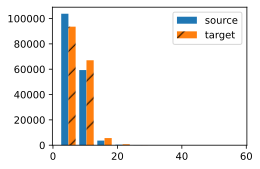

In [34]:
# Define o tamanho padrão das figuras geradas pelo matplotlib (função utilitária do D2L)
d2l.set_figsize()

# Cria um histograma com os comprimentos (número de tokens) das frases
# - source: frases em inglês
# - target: frases em francês
_, _, patches = d2l.plt.hist(
    [[len(l) for l in source],
     [len(l) for l in target]],
    label=['source', 'target']
)

# Aplica hachura (listras diagonais) às barras referentes ao 'target' (francês)
# Isso ajuda a distinguir as distribuições
for patch in patches[1].patches:
    patch.set_hatch('/')

# Adiciona a legenda no canto superior direito do gráfico
d2l.plt.legend(loc='upper right');


## Obtenção do vocabulário

In [35]:
# Cria o vocabulário a partir das frases de origem (Inglês).
# Parâmetros:
# - source: lista de frases tokenizadas (cada frase é uma lista de palavras).
# - min_freq=2: apenas palavras que aparecem pelo menos 2 vezes entram no vocabulário.

# - reserved_tokens: tokens especiais reservados usados no treinamento:
#     <pad> = padding (preenchimento para frases curtas)
#     <bos> = beginning of sentence (início da frase)
#     <eos> = end of sentence (fim da frase)
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])

# Mostra o tamanho do vocabulário em inglês (número de tokens únicos, incluindo os especiais)
len(src_vocab)


10012

In [36]:
def truncate_pad(line, num_steps, padding_token):
    """
    Trunca ou aplica padding em uma sequência de tokens.

    Parâmetros
    ----------
    line : list[int]
        Sequência de índices de tokens (ex.: frase já convertida para IDs do vocabulário).
    num_steps : int
        Tamanho fixo desejado para a sequência.
    padding_token : int
        Índice do token <pad>, usado para preencher a sequência caso seja menor.

    Retorna
    -------
    list[int]
        Sequência ajustada para o comprimento num_steps:
        - Se a sequência original for maior, é cortada (truncate).
        - Se for menor, é completada com tokens de padding (pad).
    """

    if len(line) > num_steps:
        # Se a frase for muito longa, corta para o tamanho máximo permitido
        return line[:num_steps]
    # Se for curta, completa com o token <pad> até atingir num_steps
    return line + [padding_token] * (num_steps - len(line))

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])


[3919, 80, 208, 208, 208, 208, 208, 208, 208, 208]

In [37]:
def build_array_nmt(lines, vocab, num_steps):
    """
    Transforma sequências de texto em batches (tensores) prontos para o modelo de tradução.

    Parâmetros
    ----------
    lines : list[list[str]]
        Lista de frases, onde cada frase já está tokenizada (ex.: [["go", "."], ["hi", "."]]).
    vocab : d2l.Vocab
        Vocabulário (mapeia tokens para índices numéricos).
    num_steps : int
        Tamanho fixo para cada sequência (após truncamento ou padding).

    Retorna
    -------
    array : tf.Tensor
        Tensor 2D (batch_size x num_steps) com os índices dos tokens.
    valid_len : tf.Tensor
        Tensor 1D indicando o comprimento real de cada sequência
        (desconsiderando os tokens <pad>).
    """

    # Converte cada frase (lista de palavras) para IDs do vocabulário
    lines = [vocab[l] for l in lines]

    # Adiciona o token especial <eos> (end of sentence) no final de cada frase
    lines = [l + [vocab['<eos>']] for l in lines]

    # Para cada frase: aplica truncamento/padding para ter tamanho fixo (num_steps)
    array = tf.constant([
        truncate_pad(l, num_steps, vocab['<pad>']) for l in lines
    ])

    # Calcula o comprimento "válido" de cada frase (número de tokens ≠ <pad>)
    valid_len = tf.reduce_sum(
        tf.cast(array != vocab['<pad>'], tf.int32), 1
    )

    return array, valid_len


In [38]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """
    Carrega e prepara o conjunto de dados de tradução automática (NMT - Neural Machine Translation).

    Parâmetros
    ----------
    batch_size : int
        Quantidade de exemplos por minibatch.
    num_steps : int
        Comprimento fixo das sequências (após truncamento/padding).
    num_examples : int, opcional
        Número de exemplos (pares de frases) a serem utilizados.

    Retorna
    -------
    data_iter : tf.data.Dataset
        Iterador de minibatches contendo:
            - src_array: frases em inglês (com padding/truncamento)
            - src_valid_len: comprimentos reais (sem <pad>) das frases em inglês
            - tgt_array: frases em francês (com padding/truncamento)
            - tgt_valid_len: comprimentos reais (sem <pad>) das frases em francês
    src_vocab : d2l.Vocab
        Vocabulário do idioma de origem (inglês).
    tgt_vocab : d2l.Vocab
        Vocabulário do idioma de destino (francês).
    """

    # 1. Lê o dataset bruto (fra-eng) e aplica pré-processamento
    text = preprocess_nmt(read_data_nmt())

    # 2. Tokeniza as frases (separa em listas de palavras)
    source, target = tokenize_nmt(text, num_examples)

    # 3. Cria vocabulário para inglês e francês
    #    - min_freq=2, descarta palavras raras (aparecem < 2 vezes)
    #    - reserved_tokens, adiciona tokens especiais (<pad>, <bos>, <eos>)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])

    # 4. Converte frases para arrays fixos (com <eos>, truncamento e padding)
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)

    # 5. Junta tudo em um único dataset para facilitar o batching
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)

    # 6. Retorna iterador de dados + vocabulários
    return data_iter, src_vocab, tgt_vocab





In [39]:
# Carrega os dados de tradução com batch_size=2 e comprimento fixo de 8 tokens
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8, num_examples=100)

# Itera sobre os batches do dataset
for X, X_valid_len, Y, Y_valid_len in train_iter:

    # X: tensor das frases em inglês (convertidas para IDs)
    print('X:', tf.cast(X, tf.int32))

    # X_valid_len: comprimento real de cada frase em X (desconsiderando <pad>)
    print('Comprimentos válidos de X:', X_valid_len)

    # Y: tensor das frases em francês (convertidas para IDs)
    print('Y:', tf.cast(Y, tf.int32))

    # Y_valid_len: comprimento real de cada frase em Y (desconsiderando <pad>)
    print('Comprimentos válidos de Y:', Y_valid_len)

    # Interrompe o loop após o primeiro batch
    break


X: tf.Tensor(
[[ 8 13  1  3  4  4  4  4]
 [ 9 25  1  3  4  4  4  4]], shape=(2, 8), dtype=int32)
Comprimentos válidos de X: tf.Tensor([4 4], shape=(2,), dtype=int32)
Y: tf.Tensor(
[[34  5  0  3  4  4  4  4]
 [ 5  0  3  4  4  4  4  4]], shape=(2, 8), dtype=int32)
Comprimentos válidos de Y: tf.Tensor([4 3], shape=(2,), dtype=int32)


## Treinamento do modelo

Epoch 1/30 | Loss: 1.5047 | Accuracy: 0.2818 | F1-score: 0.0110
Epoch 2/30 | Loss: 0.9691 | Accuracy: 0.3779 | F1-score: 0.0240
Epoch 3/30 | Loss: 0.8303 | Accuracy: 0.4910 | F1-score: 0.0416
Epoch 4/30 | Loss: 0.7546 | Accuracy: 0.5434 | F1-score: 0.0601
Epoch 5/30 | Loss: 0.7233 | Accuracy: 0.5657 | F1-score: 0.0563
Epoch 6/30 | Loss: 0.6905 | Accuracy: 0.6166 | F1-score: 0.0730
Epoch 7/30 | Loss: 0.6500 | Accuracy: 0.6426 | F1-score: 0.0817
Epoch 8/30 | Loss: 0.6090 | Accuracy: 0.6571 | F1-score: 0.0848
Epoch 9/30 | Loss: 0.5820 | Accuracy: 0.6592 | F1-score: 0.0900
Epoch 10/30 | Loss: 0.5671 | Accuracy: 0.6566 | F1-score: 0.0858
Epoch 11/30 | Loss: 0.5355 | Accuracy: 0.6679 | F1-score: 0.0915
Epoch 12/30 | Loss: 0.5136 | Accuracy: 0.6665 | F1-score: 0.0949
Epoch 13/30 | Loss: 0.4931 | Accuracy: 0.6811 | F1-score: 0.1204
Epoch 14/30 | Loss: 0.4723 | Accuracy: 0.6744 | F1-score: 0.1143
Epoch 15/30 | Loss: 0.4587 | Accuracy: 0.6814 | F1-score: 0.1252
Epoch 16/30 | Loss: 0.4517 | Accur

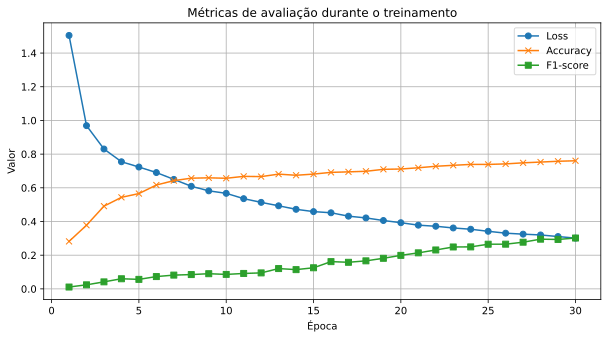

In [40]:

# Preparação do dataset

batch_size = 64
num_steps = 10
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps, num_examples=600)


# Definição do Encoder e Decoder

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.embedding = layers.Embedding(vocab_size, embed_size)
        self.rnn = layers.GRU(hidden_size, return_sequences=True, return_state=True)

    def call(self, X, hidden_state):
        X = self.embedding(X)
        output, state = self.rnn(X, initial_state=hidden_state)
        return output, state

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.rnn.units))

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.embedding = layers.Embedding(vocab_size, embed_size)
        self.rnn = layers.GRU(hidden_size, return_sequences=True, return_state=True)
        self.dense = layers.Dense(vocab_size)

    def call(self, X, state):
        X = self.embedding(X)
        output, state = self.rnn(X, initial_state=state)
        output = self.dense(output)
        return output, state


# Hiperparâmetros

embed_size = 32
hidden_size = 64
lr = 0.005
num_epochs = 30

encoder = Encoder(len(src_vocab), embed_size, hidden_size)
decoder = Decoder(len(tgt_vocab), embed_size, hidden_size)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


# Função de perda mascarada

def masked_loss(real, pred):
    mask = tf.cast(real != tgt_vocab['<pad>'], dtype=tf.float32)
    loss_ = loss_object(real, pred)
    loss_ *= mask
    return tf.reduce_mean(loss_)


# Função de treinamento por batch

def train_step(X, Y):
    batch_size = tf.shape(X)[0]
    with tf.GradientTape() as tape:
        hidden = encoder.init_state(batch_size)
        encoder_output, hidden = encoder(X, hidden)
        decoder_input = Y[:, :-1]  # todos exceto <eos>
        decoder_target = Y[:, 1:]  # todos exceto <bos>
        decoder_output, _ = decoder(decoder_input, hidden)
        loss = masked_loss(decoder_target, decoder_output)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))


    # Cálculo de Acurácia e F1-score token a token

    pred_ids = tf.argmax(decoder_output, axis=-1)

    # Corrigindo tipo para evitar erro de comparação
    pred_ids = tf.cast(pred_ids, tf.int32)
    decoder_target = tf.cast(decoder_target, tf.int32)

    mask = tf.cast(decoder_target != tgt_vocab['<pad>'], tf.bool)

    # Acurácia token a token
    correct = tf.boolean_mask(pred_ids, mask) == tf.boolean_mask(decoder_target, mask)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32)).numpy()

    # F1-score token a token (macro)
    y_true = tf.boolean_mask(decoder_target, mask).numpy().flatten()
    y_pred = tf.boolean_mask(pred_ids, mask).numpy().flatten()
    f1 = f1_score(y_true, y_pred, average='macro')

    return loss, accuracy, f1


# Treinamento principal

loss_history, acc_history, f1_history = [], [], []

for epoch in range(num_epochs):
    total_loss = 0
    total_acc = 0
    total_f1 = 0
    batch_count = 0

    for X, X_valid_len, Y, Y_valid_len in train_iter:
        batch_loss, batch_acc, batch_f1 = train_step(X, Y)
        total_loss += batch_loss
        total_acc += batch_acc
        total_f1 += batch_f1
        batch_count += 1

    loss_history.append(total_loss / batch_count)
    acc_history.append(total_acc / batch_count)
    f1_history.append(total_f1 / batch_count)

    print(f'Epoch {epoch+1}/{num_epochs} | Loss: {loss_history[-1]:.4f} | Accuracy: {acc_history[-1]:.4f} | F1-score: {f1_history[-1]:.4f}')


# Plotando métricas

plt.figure(figsize=(10,5))
plt.plot(range(1,num_epochs+1), loss_history, marker='o', label='Loss')
plt.plot(range(1,num_epochs+1), acc_history, marker='x', label='Accuracy')
plt.plot(range(1,num_epochs+1), f1_history, marker='s', label='F1-score')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.title('Métricas de avaliação durante o treinamento')
plt.grid(True)
plt.legend()
plt.show()
